# HIV 3' UTR polyA analysis

Here, we are interested in the polyA length and non-A nucleotides in HIV 3' UTR cDNA as read out by sequencing.

In [20]:
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter

In [16]:
# Define filepaths to each Read1 fastq
R1_4 = 'RTB004_S1_L001_R1_001.fastq'
R1_5 = 'RTB005_S1_L001_R1_001.fastq'
R1_6 = 'RTB006_S1_L001_R1_001.fastq'
R1_7 = 'RTB007_S1_L001_R1_001.fastq'

In [19]:
def load_polya(r1_path):
    """
    Given a path to a Read1 fastq
    Return a list of polyAs for reads with the correct flanking sequences
    """
    r1_sequences = []

    with open(r1_path) as f:
        for line in islice(f, 1, None, 4):
            r1_sequences.append(line.strip())
            
    polyA_sequences = []

    for seq in r1_sequences:
        i = seq.find("GAAGCACTCAAGGCAAG")
        j = seq.find("GTTGTTGTTGTTGTTTC")
        if i >= 0 and j >= 0 and j < i:
            polyA_sequences.append(seq[j+17:i])
    
    return polyA_sequences

In [18]:
# Load polyAs for all four samples
polyA_sequences = {'4': load_polya(R1_4),
                   '5': load_polya(R1_5),
                   '6': load_polya(R1_6),
                   '7': load_polya(R1_7)}

## HIV polyA length analysis

In [21]:
# Compute lengths for each sequence
polyA_sequence_lengths = {'4': [len(x) for x in polyA_sequences['4']],
                          '5': [len(x) for x in polyA_sequences['5']],
                          '6': [len(x) for x in polyA_sequences['6']],
                          '7': [len(x) for x in polyA_sequences['7']]}

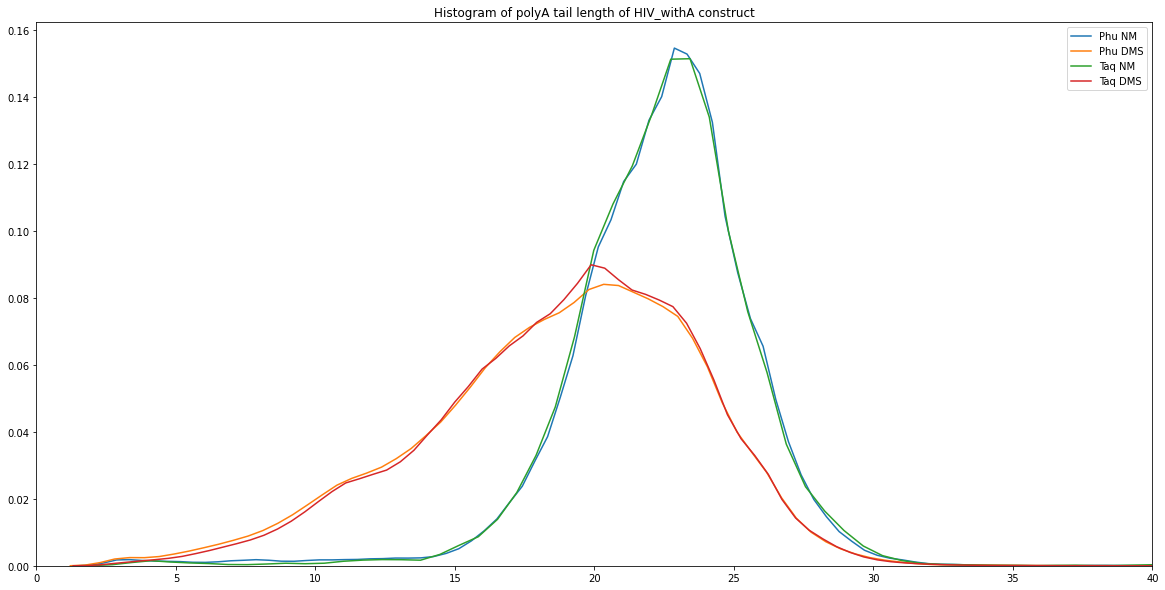

In [22]:
# Plot histogram of polyA tail lengths for all four constructs
fig = plt.figure(figsize=[20,10])
sns.distplot(polyA_sequence_lengths['4'], bins=25, hist=False, label='Phu NM')
sns.distplot(polyA_sequence_lengths['5'], bins=25, hist=False, label='Phu DMS')
sns.distplot(polyA_sequence_lengths['6'], bins=25, hist=False, label='Taq NM')
sns.distplot(polyA_sequence_lengths['7'], bins=25, hist=False, label='Taq DMS')
plt.xlim([0, 40])
plt.legend()
plt.title('Histogram of polyA tail length of HIV_withA construct')
fig.savefig('polyA_length_histogram.png')

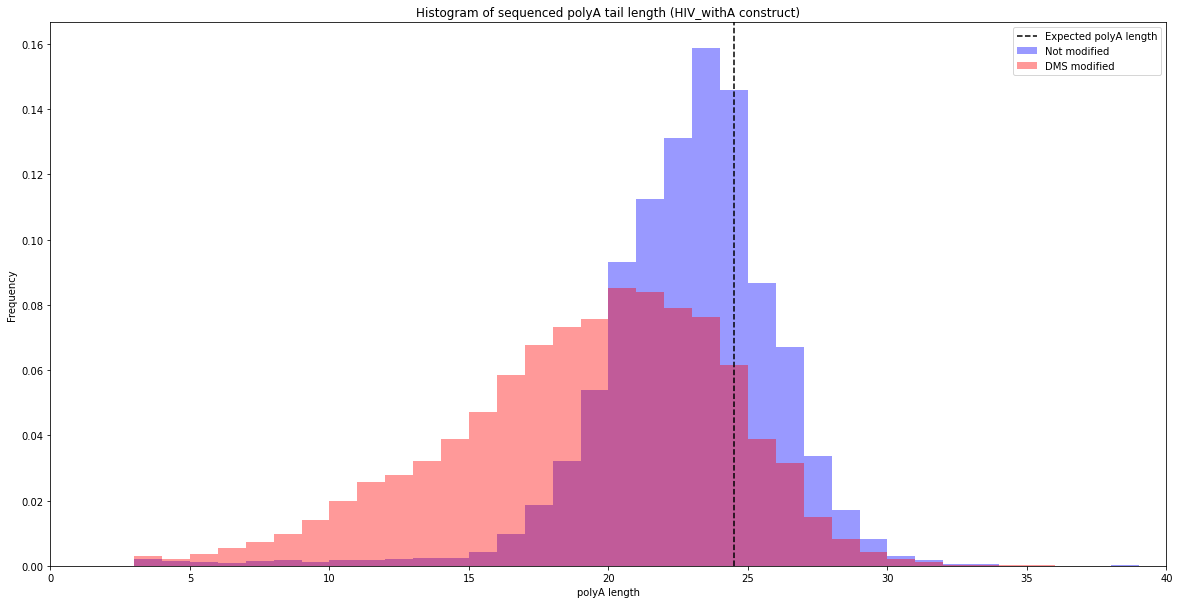

In [23]:
# Plot a histogram of just the Phusion NM and Phusion DMS samples

fig = plt.figure(figsize=[20,10])
sns.distplot(polyA_sequence_lengths['4'], hist_kws={'density': True}, hist=True, kde=False, label='Not modified', bins=np.arange(min(polyA_sequence_lengths['4']), max(polyA_sequence_lengths['4'])+1), color='blue')
sns.distplot(polyA_sequence_lengths['5'], hist_kws={'density': True}, hist=True, kde=False, label='DMS modified', bins=np.arange(min(polyA_sequence_lengths['5']), max(polyA_sequence_lengths['5'])+1), color='red')

plt.axvline(x=24.5, color='k', linestyle='--', label='Expected polyA length')
plt.legend()

plt.xlim([0, 40])
plt.title('Histogram of sequenced polyA tail length (HIV_withA construct)')
plt.xlabel('polyA length')
plt.ylabel('Frequency')
plt.rcParams.update({'font.size': 22})

fig.savefig('polyA_length_histogram.png')

In [11]:
# Dump polyA lengths to CSV

data = {'NM': np.zeros(100), 'DMS': np.zeros(100)}
for i in polyA_sequence_lengths['4']:
    data['NM'][i] += 1
    
for i in polyA_sequence_lengths['5']:
    data['DMS'][i] += 1
    
pd.DataFrame(data).to_csv('HIV_polyA_length_counts.csv')

## HIV 3' UTR polyA non-A nucleotide rate

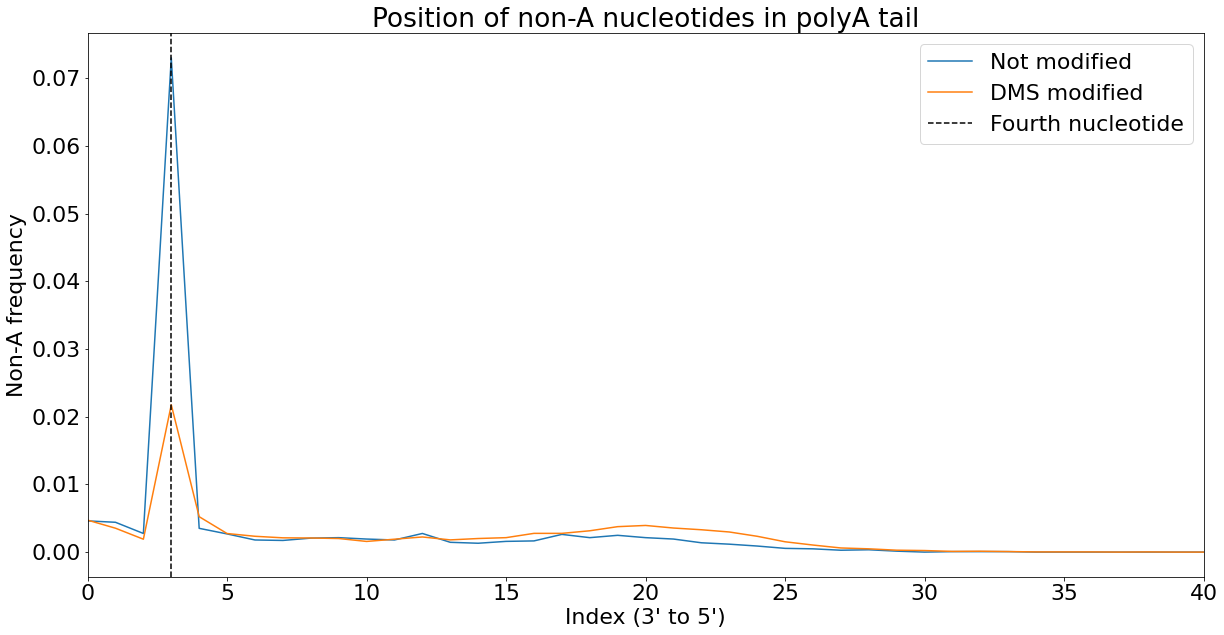

In [25]:
def count_mutation_indices(sequences, size):
    mutation_index_counter = np.zeros(100)    
    for seq in sequences:
        letters = list(seq)
        num_as = letters.count('A')
        for i, x in enumerate(letters):
            if x is not 'T':
                mutation_index_counter[i] += 1
    return mutation_index_counter/len(sequences)

mutation_indices = [count_mutation_indices(polyA_sequences['4'], 24),
                    count_mutation_indices(polyA_sequences['5'], 24),
                    count_mutation_indices(polyA_sequences['6'], 24),
                    count_mutation_indices(polyA_sequences['7'], 24)
                   ]

fig = plt.figure(figsize=[20,10])

plt.plot(mutation_indices[0], label='Not modified')
plt.plot(mutation_indices[1], label='DMS modified')

plt.axvline(x=3, color='k', linestyle='--', label='Fourth nucleotide')
plt.legend()

plt.xlim([0, 40])
plt.title('Position of non-A nucleotides in polyA tail')
plt.xlabel('Index (3\' to 5\')')
plt.ylabel('Non-A frequency')
plt.rcParams.update({'font.size': 22})

fig.savefig('polyA_nonA_frequencies.png')